![](https://i.pinimg.com/564x/77/c7/64/77c764e1334a948856e70490cb0d7110.jpg)

# Accelerometer Calibration

Although accelerometers come from the factory calibrated to a rough level for drop detection or car impact detection, this calibration is not sufficient for inerital navigation. Here we are going to follow the AN4508 application note on how to calibrate an accelerometer using least squares.

Following Table 1, we are going to collect measurements in the following 6 orienations:

- x up/down
- y up/down
- z up/down

Then rely on least squares ($Ax=B$) to calculate the misalignments and offsets to recover the *true* measurements. `numpy.linalg.lstsq()` return the least-squares solution to a linear matrix equation.Solves the equation a x = b by computing a vector x that minimizes the Euclidean L2-norm ($|| b – a x ||^2$). 

## References

- AN4508: [Parameters and calibration of a low-g 3-axis accelerometer](AN4508.pdf)
- Vectornav: [Accelerometer](https://www.vectornav.com/support/library/accelerometer)
- [Least squares fitting with Numpy and Scipy](https://mmas.github.io/least-squares-fitting-numpy-scipy)
- GeeksforGeeks: [Numpy Linear Algebra](https://www.geeksforgeeks.org/numpy-linear-algebra/)
- Wikipedia: [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance)
- Oxford Reference: [International Gravity Formula](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803100007626)

## Accelerometer Model

We can view the sensor model as a the transformation of the *true* acceleration measurement ($\vec{a}$) morphed into a noisy measurement ($\vec{am}$) due to misalignments, biases (offsets), etc. Mathematically it is:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} (\vec{am} - \vec{b}) \\
\begin{bmatrix}
a_x \\ a_y \\ a_z
\end{bmatrix} &= 
\begin{bmatrix}
1 & M_{xy} & M_{xz} \\
M_{yx} & 1 & M_{yz} \\
M_{zx} & M_{zy} & 1
\end{bmatrix}
\begin{bmatrix}
\frac{1}{S_x} & 0 & 0\\
0 & \frac{1}{S_y} & 0\\
0 & 0 & \frac{1}{S_z}
\end{bmatrix}
\begin{bmatrix}
am_x - b_x \\ am_y - b_y \\ am_z - b_z
\end{bmatrix} 
\end{align*}
$$

where $\mathbf{M}$ is cross coupling due to non-orthogonal sensor axes created during senors construction, $\mathbf{S}$ is sensitivity errors, and $\vec{b}$ are constant bias offsets. Now we can solve and get the *true* acceleration, but then we are going to put it into a form for least squares that looks like $Ax=B$. First we need to do a little rearranging:

$$
\begin{align*}
\vec{a} &= \mathbf{M} \mathbf{S} \vec{am} + \mathbf{M} \mathbf{S} \vec{b} \\
\vec{a} &= [\mathbf{M} \mathbf{S} | \vec{b}]_{3x4}
\begin{bmatrix}
am_x & am_y & am_z & 1
\end{bmatrix}^T \\
\vec{a} &=[\vec{am} | 1] [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{1x4} [x]_{4x3}
\end{align*}
$$

where $[\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}$ is a constant matrix of correction coefficients. Now, for least squares, $A$ becomes our noisy measurements and $B$ is our ideal states. In order to clean up our noisy measurements, we just post-multiply by our $x$ matrix (which least squares finds). So for $n$ samples, our solution becomes:

$$
\begin{align*}
\vec{a}_{nx3} &= [\vec{am} | 1]_{nx4} [\mathbf{M} \mathbf{S} | \vec{b}]^T_{4x3}\\
B &= A_{nx4} [x]_{4x3}
\end{align*}
$$

where $B$ is $\begin{bmatrix} 0 & 0 & g \end{bmatrix}^T_{nx3}$ for z-axis up and $\begin{bmatrix} 0 & 0 & -g \end{bmatrix}^T_{nx3}$ for z-axis down. 

## Setup

In [67]:
import numpy as np # matrix manipulations
import os
from scipy import linalg

from squaternion import Quaternion

import pandas as pd

%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt

from math import radians as deg2rad
from math import degrees as rad2deg
from math import pi, sin, sqrt
from math import copysign

from slurm import storage
from collections import deque
from datetime import datetime
from pprint import pprint

## Gravity Model

Gravity is not constant everywhere. Due to the shape of the Earth, the gravity changes based on altitude (the higher you go, the smaller it is) and the latitude you are located. So put another way, since the Earth buldges out at the equator, you are farther from the center of the Earth there. While at the top (or bottom) of the world, you are closer to the center of the Earth. Thus, gravity has a weaker pull at the equator and stronger pull at the poles. Looking at the plot below, the change isn't huge:

- Equator: 9.78 m/sec$^2$
- Poles: 9.832 m/sec$^2$

In [3]:
gps_lat = 38.785809

In [4]:
def gravity(lat):
    """Based off the Oxford reference for the gravity formula at sealevel.
    
    lat: latitude in degrees
    """
    lat *= pi/180
    return 9.78*(1 + 0.0053024*sin(lat)**2 - 0.0000058*sin(2*lat)**2)

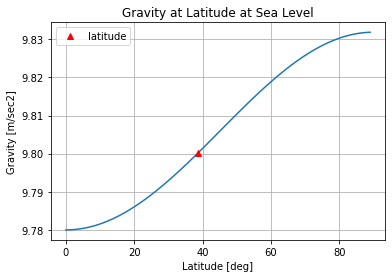

In [142]:
plt.plot(range(90), [gravity(x) for x in range(90)])
plt.plot([gps_lat], [gravity(gps_lat)], 'r^', label="latitude")
plt.ylabel("Gravity [m/sec2]")
plt.xlabel("Latitude [deg]")
plt.title("Gravity at Latitude at Sea Level")
plt.grid(True)
plt.legend()
plt.show();

## Data

Let's load a bunch of data gathered from an IMU and mounted in a [calibration mount](https://www.thingiverse.com/thing:2841844). The mount allows me to grab 10 seconds of data, then rotate the IMU to another one of its faces. I collected a bunch of data on the $\pm$x-axis, $\pm$y-axis, and $\pm$z-axis ... these 6 are the minimum, but you can collect more.

In [14]:
def ideal(a):
    """
    I don't record what the ideal gravity value is going to be when I collect
    the data ... I don't need to. Since this is static, just figuring out what
    value is the largest tells me what idea should be.
    """
    m = max(a)
    n = min(a)
    if abs(m) > abs(n):
        v = m
    else:
        v = n
    index = a.index(v)
    d = [0,0,0]
    d[index] = copysign(1.0, v)
    return d

In [109]:
!ls -alh *.pickle

-rw-rw-r-- 1 kevin kevin 208K Aug 30 12:27 lsm6sox-cal-data.pickle
-rw-rw-r-- 1 kevin kevin  16K Aug 30 10:07 test.pickle


In [110]:
file = "lsm6sox-cal-data.pickle"

def condition(data):
    """
    Create a noisey measurement numpy array and an ideal numpy array from
    the data.
    """
    accel = []
    iaccel = []
    for d in data:
        a = d['a']
        ia = ideal(a)
        a += (1,)
        accel.append(a)
        iaccel.append(ia)
    return np.array(accel), np.array(iaccel)

data = storage.read(file)
accel, iaccel = condition(data)

print(f">> data points: {accel.shape}")

>> data points: (2757, 4)


# Calibration

Going to use `numpy` to calculate the least squares estimate of what the corrections are ... $[\bf{MS} | b]^T$ from above.

In [111]:
def least_squares_fit(A, B):
    """B = A*x which is: ideal = noisy*x => [n,3] = [n,4][4,3]
    ideal = [n,3] = [x,y,z]
    noisy = [n,4] = [x,y,z,1]: the 1 accounts for the biases
    A = [4,3]: this is a bunch of coefficient matrices [[S],[H]]
      S = [3,3] 
      H = [1,3] 
    """
    # Need to extend A and B
    # A = np.hstack((A, np.ones(len(A)).reshape(-1, 1)))
    # print(A)

    X, res, rank, s = np.linalg.lstsq(A, B, rcond=None)
    print(f"Rank: {rank}")
    print(f"Singular values: {s}")
    print(f"Sum residual error: {np.sum(res)}")
    return X

In [113]:
A = least_squares_fit(accel, iaccel)
print("--------------------------------")
print(A)

Rank: 4
Singular values: [318.0685513  316.30697429 257.08536773  50.05835058]
Sum residual error: 0.05342230838934214
--------------------------------
[[ 1.01249589e-01  2.41981057e-05 -7.91695914e-04]
 [-8.55583032e-04  1.01811396e-01  1.51069910e-03]
 [ 3.13780091e-04 -1.56290269e-03  1.02164867e-01]
 [ 4.01592509e-03  8.32960564e-03 -2.47638123e-02]]


In [143]:
def plot(xx, n):
    n = n.dot(xx)
    c = pd.DataFrame(n, columns=["x","y","z"])
    cx,cy,cz = c.mean()
    csx,csy,csz = 1000*c.std()
    cm = (cx**2 + cy**2 + cz**2)**0.5
#     print(f">> Mean: {c.mean()}")
#     print(f">> STD: {c.std()}")

    title=f"$\mu$: ({cx:.2f},{cy:.2f},{cz:.2f})m/sec2;  $\sigma$: ({csx:.0f},{csy:.0f},{csz:.0f})mm/sec2"
    c.plot(
        subplots=True, 
        grid=True, 
        title=title);

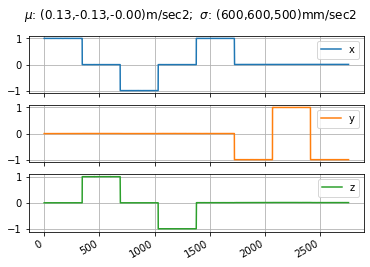

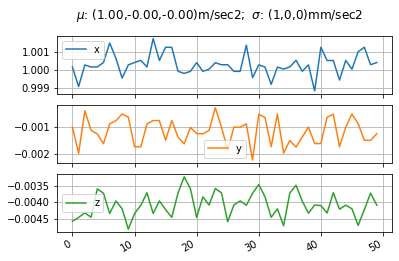

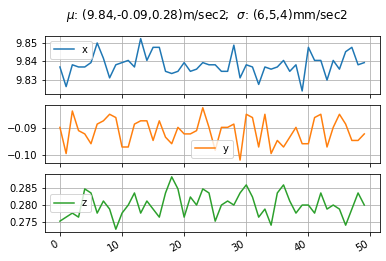

In [144]:
plot(A, accel)          # calibrated
plot(A, accel[:50,:])          # calibrated
plot(np.eye(4,3), accel[:50,:]) # uncalibrated

# Gyros

The gyros will follow a simpler method. Basically, when all of this data was taken, the IMU was stationary, hence, all values should be zero. So we are going to find the best bias values to compensate.

Ideally, we would spin the gyros around all 6 orientations at a known speed and gather data to use in a least squared solution. Unfortunatly, I do not have the equipment to test that way.

In [145]:
def plot_gyros(n):
#     n = n.dot(xx)
    c = pd.DataFrame(n, columns=["x","y","z"])
    cx,cy,cz = c.mean()
    csx,csy,csz = 1000*c.std()
    cm = rad2deg(1000*(cx**2 + cy**2 + cz**2)**0.5)
#     print(f">> Mean: {c.mean()}")
#     print(f">> STD: {c.std()}")

    title=f"$\mu$: ({cx:.2f},{cy:.2f},{cz:.2f})rps;  $\sigma$: ({csx:.0f},{csy:.0f},{csz:.0f})mrps; |$\mu$|: {cm:.4f}mdps"
    c.plot(
        subplots=True, 
        grid=True, 
        title=title);

In [146]:
def condition_gyros(data):
    gyros = []
    for d in data:
        g = d['g']
        gyros.append(g)
    return np.array(gyros)

gnoisy = condition_gyros(data)
print(gnoisy.shape)

(2757, 3)


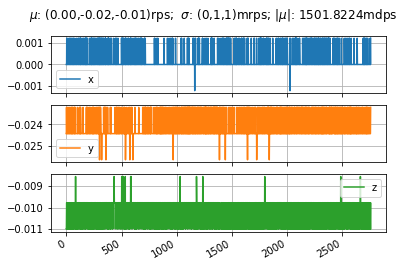

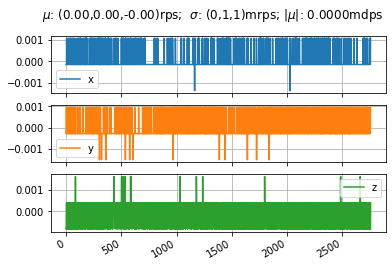

In [147]:
# let's look at the raw data to get a starting point for the biases
plot_gyros(gnoisy)

c = pd.DataFrame(gnoisy, columns=["x","y","z"])
bias = c.mean()
plot_gyros(gnoisy - np.array(bias))

In [135]:
# Now let's see how these work on all 6 orientations
G = np.vstack((np.eye(3),bias))
print(G)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.52439349e-04 -2.41567622e-02 -1.01726677e-02]]


# Save Parameters

In [119]:
def save_parameters(a, g):
    aa = np.resize(a, (1, 12))[0].tolist()
    gg = np.resize(g, (1, 12))[0].tolist()
    params = {}
    params["lsm6sox"] = {}
    params["lsm6sox"]["timestamp"] = datetime.now()
    params["lsm6sox"]["accel"] = {"data": aa, "shape": a.shape, "dtype": str(a.dtype)}
    params["lsm6sox"]["gyro"] = {"data": gg, "shape": g.shape, "dtype": str(g.dtype)}
    
    return params

params = save_parameters(A, G)
    
pprint(params)

{'lsm6sox': {'accel': {'data': [0.10124958887273922,
                                2.419810569214096e-05,
                                -0.0007916959137182327,
                                -0.0008555830320481476,
                                0.10181139633682373,
                                0.001510699098028933,
                                0.0003137800905107515,
                                -0.0015629026939724747,
                                0.10216486651751974,
                                0.004015925094103206,
                                0.008329605644502025,
                                -0.024763812324729968],
                       'dtype': 'float64',
                       'shape': (4, 3)},
             'gyro': {'data': [1.0,
                               0.0,
                               0.0,
                               0.0,
                               1.0,
                               0.0,
                               0.0,
         

In [120]:
storage.write("lsm6sox-accel-gyro.yaml", params)

In [121]:
!cat lsm6sox-accel-gyro.yaml

lsm6sox:
  accel:
    data:
    - 0.10124958887273922
    - 2.419810569214096e-05
    - -0.0007916959137182327
    - -0.0008555830320481476
    - 0.10181139633682373
    - 0.001510699098028933
    - 0.0003137800905107515
    - -0.0015629026939724747
    - 0.10216486651751974
    - 0.004015925094103206
    - 0.008329605644502025
    - -0.024763812324729968
    dtype: float64
    shape:
    - 4
    - 3
  gyro:
    data:
    - 1.0
    - 0.0
    - 0.0
    - 0.0
    - 1.0
    - 0.0
    - 0.0
    - 0.0
    - 1.0
    - 0.0001524393485238419
    - -0.024156762226978153
    - -0.010172667688119676
    dtype: float64
    shape:
    - 4
    - 3
  timestamp: 2020-08-30 12:32:45.540809


In [122]:
p = storage.read("lsm6sox-accel-gyro.yaml")
for k,v in p["lsm6sox"].items():
    if isinstance(v, dict):
        print(f"[{k}]")
        for kk, vv in v.items():
            if kk == "data":
                vv = np.array(vv, dtype=np.float64)
                vv.resize((4,3))
                print(f"- {kk}: {vv}")
            else:
                print(f"   => {kk}: {vv}")
    else:
        print(f"[{k}]: {v}")

[accel]
- data: [[ 1.01249589e-01  2.41981057e-05 -7.91695914e-04]
 [-8.55583032e-04  1.01811396e-01  1.51069910e-03]
 [ 3.13780091e-04 -1.56290269e-03  1.02164867e-01]
 [ 4.01592509e-03  8.32960564e-03 -2.47638123e-02]]
   => dtype: float64
   => shape: [4, 3]
[gyro]
- data: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.52439349e-04 -2.41567622e-02 -1.01726677e-02]]
   => dtype: float64
   => shape: [4, 3]
[timestamp]: 2020-08-30 12:32:45.540809
